In [1]:
library(tidyverse)
library(broom)
library(ggplot2)
library(dplyr)
library(car)
library(repr)
library(infer)
library(modelr)
library(qqplotr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap



Attaching package: ‘qqplotr’


The following objects are masked from ‘package:ggplot2’:

    stat_qq_line, StatQqLine




# Data Description #
The dataset is come from https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries/data. ai-jobs.net Salaries aggregate this data. It includes 607 observations and 11 variables. More specific information here:

- `work_year`:     **Numerical**.     The year the salary was paid.

- `experience_level`: **Categorical**.  The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director

- `employment_type`:  **Categorical**.  The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance

- `job_title`:    **Categorical**.     The role worked in during the year.

- `salary`:       **Numerical**.      The total gross salary amount paid.
 
- `salary_currency`: **Categorical**.   The currency of the salary paid as an ISO 4217 currency code.

- `salary_in_usd`:   **Numerical**.   The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).

- `employee_residence`: **Categorical**. Employee's primary country of residence in during the work year as an ISO 3166 country code.

- `remote_ratio`:   **Ordinal Categorical**.    The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%)

- `company_location`: **Categorical**.  The country of the employer's main office or contracting branch as an ISO 3166 country code.

- `company_size`:  **Ordinal Categorical**.     The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large)

In [2]:
salary_data <- read_csv('ds_salaries.csv')

head(salary_data) # number of variables: 11

nrow(salary_data) #number of observations: 607

sum(is.na(salary_data)) #check and clean data

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


[1] 607

[1] 0

# Question #

> How do the experience level and remote work ratio impact salaries in the data science field?

- For the quantitative response salary and categorical predictor expercience leverl, we use the data to generate a boxplot to visualize the distribution of salaries across different experience levels.
- For the quantitative response salary and ordinal categorical predictor remote ratio, we use the data to generate a boxplot to visualize the distribution of salaries across different remote ratios.
- And we can also visualize the data with a combined plot, so that illustrates the interaction between experience level and remote ratio on salary using regression lines.

We focus on inference, as we are interested in how experience level and remote work ratio affect salary.
Regression model help infer the relationships and significance of the predictors, while visualizations help us drawing inferences about the distributions and potential interactions between variables.

In [3]:
variables <- 
    salary_data %>%
    select(experience_level, salary_in_usd, remote_ratio)

In [4]:
# Convert experience_level to a factor
variables$experience_level <- factor(variables$experience_level, levels = c("EN", "MI", "SE", "EX"))

# Convert remote_ratio to a factor with ordered levels
variables$remote_ratio <- factor(variables$remote_ratio, levels = c(0, 50, 100), ordered = TRUE)
head(variables)

experience_level,salary_in_usd,remote_ratio
<fct>,<dbl>,<ord>
MI,79833,0
SE,260000,0
SE,109024,50
MI,20000,0
SE,150000,50
EN,72000,100


# Visualization #

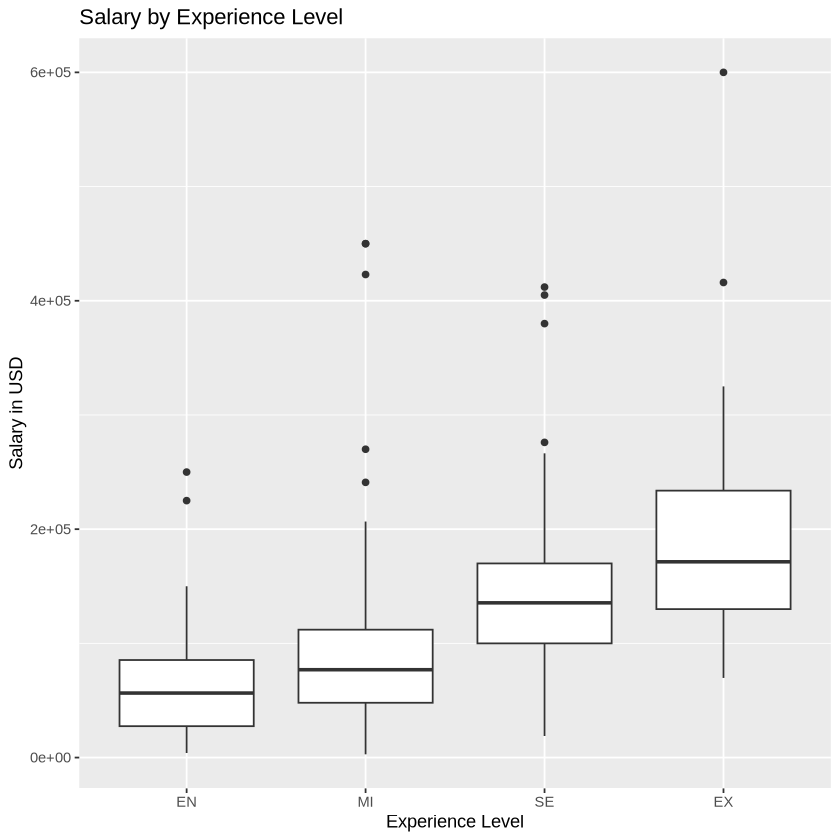

In [5]:
# Boxplot for experience_level
ggplot(variables, aes(x = experience_level, y = salary_in_usd)) +
    geom_boxplot() +
    ggtitle("Salary by Experience Level")+
    labs(x = "Experience Level", y = "Salary in USD")


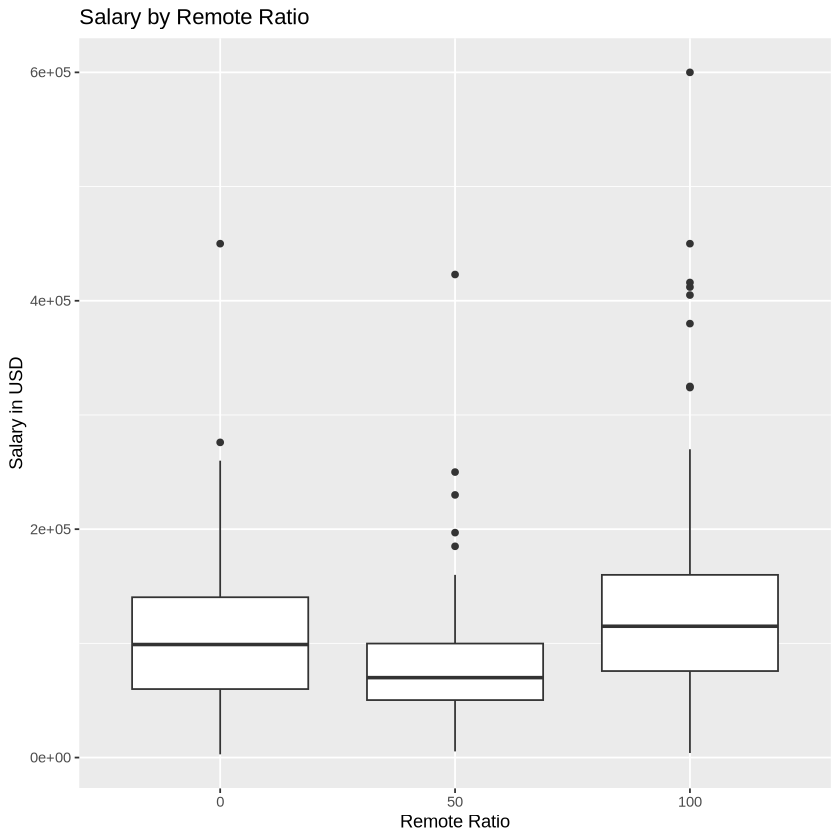

In [6]:
# Boxplot for remote_ratio
ggplot(variables, aes(x = remote_ratio, y = salary_in_usd)) +
    geom_boxplot() +
    ggtitle("Salary by Remote Ratio")+
    labs(x = "Remote Ratio", y = "Salary in USD")

`geom_smooth()` using formula = 'y ~ x'


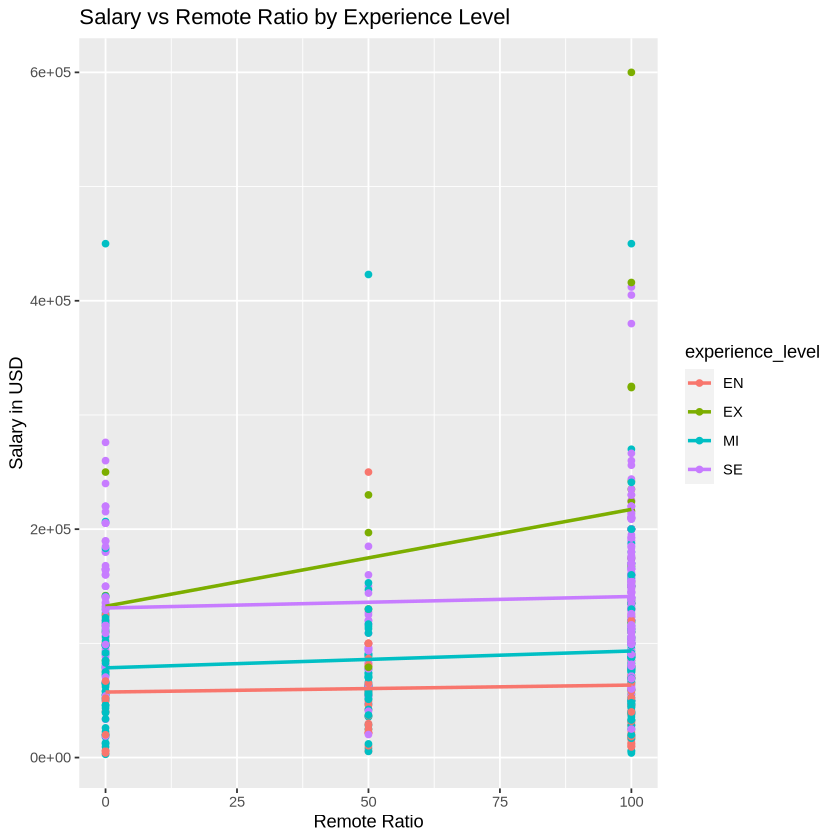

In [7]:
# Combined with LR line
ggplot(salary_data, aes(x = remote_ratio, y = salary_in_usd, color = experience_level)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Salary vs Remote Ratio by Experience Level")+
    labs(x = "Remote Ratio", y = "Salary in USD")


# Method #

The Method applied in my project is **Multiple Linear Regression**, it is appropriate because it allows us to model the relationship between the quantitative response variable (salary_in_usd) and multiple predictor variables

### Assumptions ###
- First, observations are independent of each other.
- Second, residuals have equal variance (Homoscedasticity) for all levels of the predictors.
- Third, residuals are normally distributed.
- Last, predictors and response variable are linearly associate.

### Limitations ###
- High correlation between predictor variables (Multicollinearity) would affect the variance of the coefficient estimates and make the model unstable.
- Outliers will make the disproportionate model, and skew the results.

# Further Plan #

`We may do some test like vif, qqplot, residual etc to help us improve our model.`

In [8]:
model<-lm(salary_in_usd~experience_level+remote_ratio, data=variables)
summary(model)
tidy(model,conf.int=TRUE)


Call:
lm(formula = salary_in_usd ~ experience_level + remote_ratio, 
    data = variables)

Residuals:
    Min      1Q  Median      3Q     Max 
-135947  -39223   -6420   26960  394312 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)           58674       6639   8.838  < 2e-16 ***
experience_levelMI    24970       7796   3.203  0.00143 ** 
experience_levelSE    72203       7590   9.513  < 2e-16 ***
experience_levelEX   134850      13683   9.855  < 2e-16 ***
remote_ratio.L         6632       4467   1.485  0.13812    
remote_ratio.Q        18306       5721   3.200  0.00145 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61210 on 601 degrees of freedom
Multiple R-squared:  0.2621,	Adjusted R-squared:  0.256 
F-statistic:  42.7 on 5 and 601 DF,  p-value: < 2.2e-16


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),58674.116,6639.186,8.837547,1.076079e-17,45635.293,71712.94
experience_levelMI,24970.402,7795.737,3.203084,1.431543e-03,9660.206,40280.60
experience_levelSE,72203.139,7589.820,9.513156,4.399854e-20,57297.347,87108.93
experience_levelEX,134850.548,13683.083,9.855275,2.431400e-21,107978.081,161723.01
remote_ratio.L,6632.029,4466.650,1.484788,1.381242e-01,-2140.110,15404.17
remote_ratio.Q,18306.248,5721.142,3.199754,1.447902e-03,7070.388,29542.11


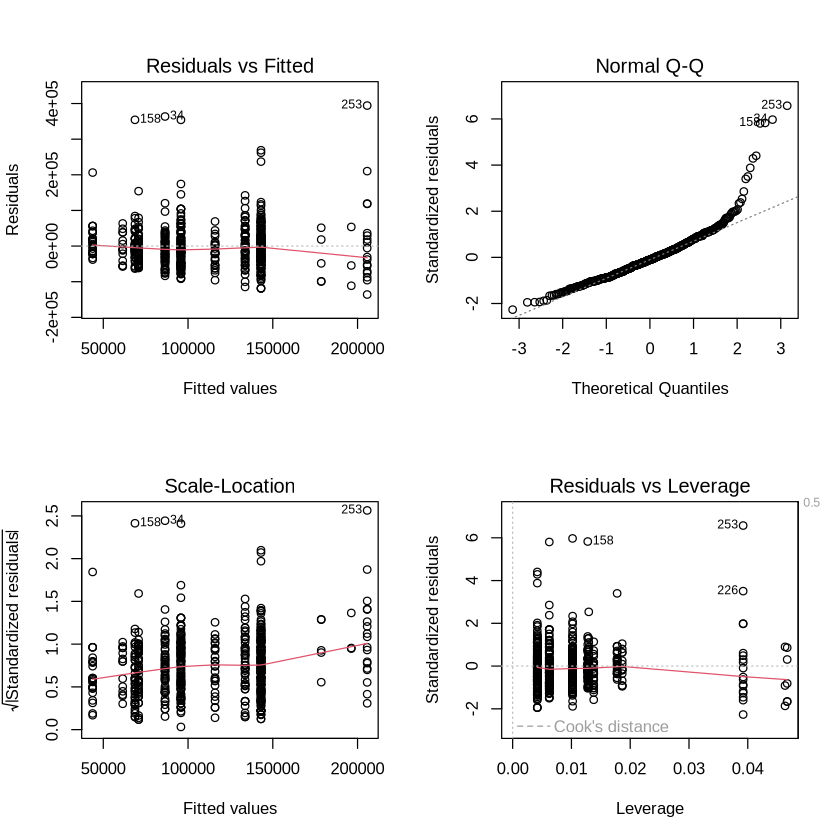

In [9]:
par(mfrow=c(2,2))
plot(model)

In [10]:
vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
experience_level,1.05008,3,1.008178
remote_ratio,1.05008,2,1.012292
